In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 01/06/2022

    Code description :
    __________________
    Consider the inverse problem of a noisy linear forward model: y=Ax+n.
    Calibrate the choice of the regularization parameters using PyUnLocBox.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),2),'utils'))

from interferometric_lensless_imaging import *
from graphics import *
from functions import snr

\begin{equation*}
    \boldsymbol y = \boldsymbol{Ax} 
\end{equation*}

In [2]:
"Set the parameters of the problem"
np.random.seed(0)
N = 500
M = 100
maxit=500
maxit_prox_TV = 80
rtol=1e-8

x = np.zeros(N)
n_piece = 4
randvals = np.random.randint(30, size=n_piece) 
cuts = np.sort((np.random.rand(n_piece-1)*N).astype(int))
x[:cuts[0]] = randvals[0]
x[cuts[-1]:] = randvals[-1]
for i in range(n_piece-2):
    x[cuts[i]:cuts[i+1]] = randvals[i+1]

Lagrangian formulation

\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}}
\end{equation*}

Using Forward-Backward, the iterates go like

\begin{equation*}
    \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right)
\end{equation*}

with convergence rate in $\mathcal O(1/k)$ if $\gamma<2/L$ where $L$ is the Lipschitz constant of $\nabla f$, i.e. 
\begin{equation*}
    \lvert \nabla f(x)-\nabla f(y) \rvert \le L\lvert x-y \rvert.
\end{equation*}

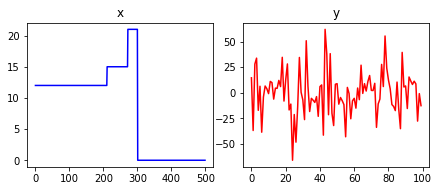

Solution found after 500 iterations:
    objective function f(sol) = 1.520188e+01
    stopping criterion: MAXIT


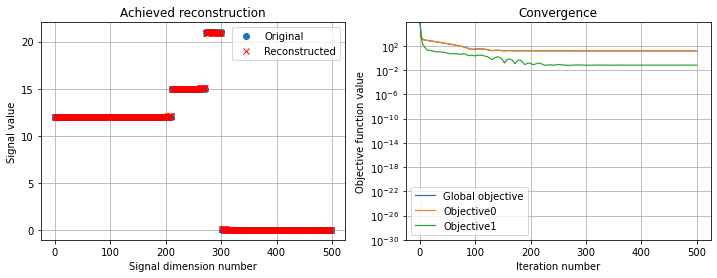

SNR: 54.15 dB


In [3]:
A = np.random.randn(M, N)/np.sqrt(M)
y = A @ x 

fig=plt.figure(figsize=(6,3))
axs = subplot_axs(fig,1,2)
axs[0].plot(x, 'b-')
axs[1].plot(y, 'r-')
axs[0].set_title('x')
axs[1].set_title('y')
plt.show()

A_op = lambda xin: A@xin
At_op = lambda y: A.T@y
nu = eval_nu(np.random.randn(N), A_op, At_op, nb_iter=50)*1.01
adjoint = At_op(y)

f1 = functions.norm_tv(maxit=maxit_prox_TV, dim=1, lambda_=0.5)
f2 = functions.norm_l2(y=y, A=A_op, At=At_op, nu=nu, lambda_=1/2)
solver = solvers.forward_backward(step=1/nu, nu=nu)
# x0 = np.ones((N,N))
x0 = adjoint
ret = solvers.solve([f1, f2], x0, solver, rtol=rtol, maxit=maxit)
xhat = ret['sol']

show_rec1D(x, xhat, objective=ret['objective'], log_scale=True, linewidth=1.2)

Observe the effect of an operator which is not normalised, i.e. 
\begin{equation*}
    \lVert \boldsymbol A^* \boldsymbol A x \rVert^2 = \nu \lVert x \rVert^2, \nu \neq 1 
\end{equation*}

In this case, the weight between the fidelity term and the prior must be adapted as  

\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \textcolor{red}{\nu} \lambda \lVert \boldsymbol u \rVert_{\text{TV}}
\end{equation*}

Solution found after 500 iterations:
    objective function f(sol) = 1.727264e+02
    stopping criterion: MAXIT


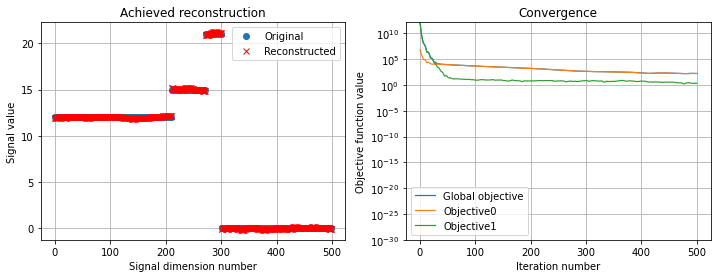

SNR: 42.78 dB


In [4]:
A2 = np.random.randn(M, N)
y2 = A2 @ x 

A_op2 = lambda xin: A2@xin
At_op2 = lambda y: A2.T@y
nu2 = eval_nu(np.random.randn(N), A_op2, At_op2, nb_iter=50)*1.01
adjoint2 = At_op2(y2)

f3 = functions.norm_tv(maxit=maxit_prox_TV, dim=1, lambda_=0.5*np.sqrt(M))
f4 = functions.norm_l2(y=y2, A=A_op2, At=At_op2, nu=nu2, lambda_=1/2)
solver2 = solvers.forward_backward(step=1/nu2, nu=nu2)
# x0 = np.ones((N,N))
x0 = adjoint2
ret2 = solvers.solve([f3, f4], x0, solver2, rtol=rtol, maxit=maxit)
xhat = ret2['sol']

show_rec1D(x, xhat, objective=ret2['objective'], log_scale=True, linewidth=1.2)

Check acceleration with FISTA works

Solution found after 2000 iterations:
    objective function f(sol) = 4.542136e+03
    stopping criterion: MAXIT
Solution found after 2000 iterations:
    objective function f(sol) = 5.873388e+05
    stopping criterion: MAXIT


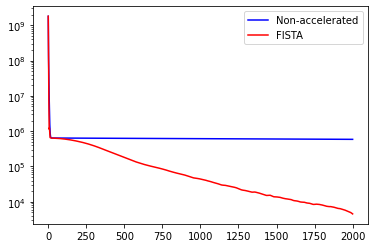

In [5]:
maxit_comp = 2000

ret = solvers.solve([f1, f2], x0, solver, rtol=rtol, maxit=maxit_comp)

"Non-accelerated version"
solver_nonacc = solvers.forward_backward(step=1/nu, nu=nu, accel=None)
ret_nonacc = solvers.solve([f1, f2], x0, solver_nonacc, rtol=rtol, maxit=maxit_comp, verbosity='LOW')
xhat_nonacc = ret_nonacc['sol']

"Compare slow and fast"
plt.figure()
plt.plot(np.sum(ret_nonacc['objective'], axis=1), 'b', label='Non-accelerated')
plt.plot(np.sum(ret['objective'], axis=1), 'r', label='FISTA')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

Plotting $SNR (\lambda)$

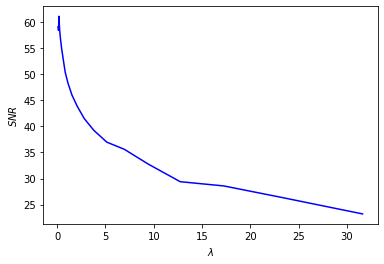

In [6]:
lambdas = np.logspace(-1,1.5, 20)
snrs = np.zeros(len(lambdas))

for i, lambda_ in enumerate(lambdas):
    f1 = functions.norm_tv(maxit=maxit_prox_TV, dim=1, lambda_=lambda_)
    x0 = adjoint
    ret = solvers.solve([f1, f2], x0, solver, rtol=rtol, maxit=maxit, verbosity='NONE')
    xhat = ret['sol']
    snrs[i] = snr(x, xhat)

plt.figure()
plt.plot(lambdas, snrs, 'b')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$SNR$')
plt.show()

### Adapting $\lambda$ between meta-iterations

The idea is that as $\boldsymbol y = \boldsymbol{Ax} + \boldsymbol n$ with $\epsilon \approx \lVert \boldsymbol n \rVert$, we should expect from the error at the end of a meta-iteration to tend towards $\epsilon$. If the error is too big, we can have $\underbrace{\lVert \boldsymbol{Ax} - \boldsymbol y\rVert}_{\epsilon^{(k)}} \gg \epsilon$. In this case, one must decrease the weight of the prior term $\lambda$. This parameter is adapted as
$
    \lambda^{(k+1)} = \lambda^{(k)} \frac{\epsilon}{\epsilon^{(k)}}
$

Solution found after 1 iterations:
    objective function f(sol) = 7.686803e-02
    stopping criterion: RTOL


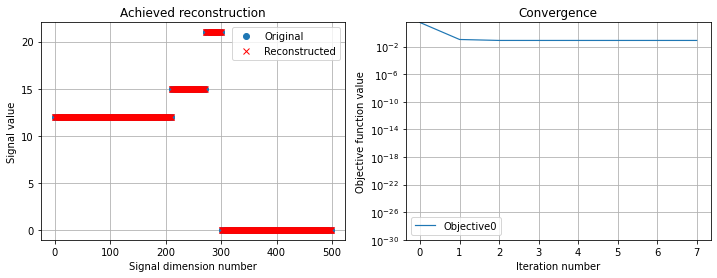

SNR: 95.14 dB


In [7]:
SNR_target = 100
epsilon = np.linalg.norm(x)*10**(-SNR_target/20)
bigit = 8


lamb = 1
f_hat = np.zeros(N)
lambs = np.zeros(bigit)
objectives = np.zeros(bigit)
i=0
while (i<bigit): 
    x0 = f_hat
    f1 = functions.norm_tv(maxit=maxit_prox_TV, dim=1, lambda_=lamb)
    ret = solvers.solve([f1, f2], x0, solver, rtol=rtol, maxit=maxit, verbosity='NONE')
    f_hat = ret['sol']
    lamb *= epsilon/np.linalg.norm(A_op(ret['sol'])-y)
    lambs[i] = lamb
    objectives[i] = np.sum(np.array(ret['objective'])[-1,:])
    i+=1

ret = solvers.solve([f1, f2], x0, solver, rtol=rtol, maxit=maxit)
xhat = ret['sol']

show_rec1D(x, xhat, objective=objectives, log_scale=True, linewidth=1.2)

Noisy problem

\begin{equation*}
    \boldsymbol y = \boldsymbol{Ax} + \boldsymbol n
\end{equation*}

Plotting $SNR(\sigma_n)$

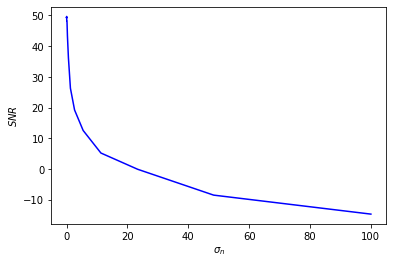

In [8]:
sigs = np.logspace(-4,2, 20)
snrs = np.zeros(len(sigs))

f1 = functions.norm_tv(maxit=maxit_prox_TV, dim=1, lambda_=1)
solver = solvers.forward_backward(step=1/nu, nu=nu)
x0 = np.zeros(N)

for i, sig in enumerate(sigs):
    n = sig*np.random.randn(M)
    y = A @ x + n
    f2 = functions.norm_l2(y=y, A=A_op, At=At_op, nu=nu, lambda_=1/2)
    ret = solvers.solve([f1, f2], x0, solver, rtol=rtol, maxit=maxit, verbosity='NONE')
    xhat = ret['sol']
    snrs[i] = snr(x, xhat)

plt.figure()
plt.plot(sigs, snrs, 'b')
plt.xlabel(r'$\sigma_n$')
plt.ylabel(r'$SNR$')
plt.show()

Constrained problem

\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\lVert \boldsymbol u \rVert_{\text{TV}}~\text{s.t.}~\lVert \boldsymbol y - \boldsymbol{Au} \rVert \le \epsilon
\end{equation*}

Solution found after 3000 iterations:
    objective function f(sol) = 6.709972e+00
    stopping criterion: MAXIT


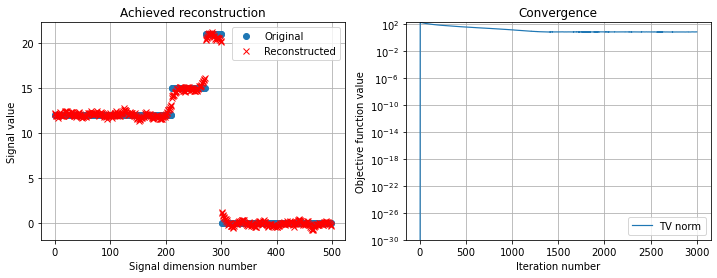

SNR: 30.66 dB


In [9]:
y = A @ x 

f1 = functions.norm_tv(maxit=maxit_prox_TV, dim=1, lambda_=0.08)
f2 = functions.proj_b2(epsilon=1e-6, y=y, A=A, tight=True, nu=nu)
solver = solvers.douglas_rachford(step=1e-2)

x0 = np.zeros(N)
ret = solvers.solve([f2, f1], x0, solver, rtol=rtol, maxit=3000, verbosity='LOW')
xhat = ret['sol']
objective = np.array(ret['objective'])

show_rec1D(x, xhat, objective=objective[:,1], labels=['TV norm'], log_scale=True, linewidth=1.2)